# 📚 Libraries 📚

In [ ]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

import numpy as np
import math
import scipy as sp
from scipy.integrate import solve_ivp

In [2]:
import importlib
import decay_chains as dc
from decay_chains import Isotope
from importlib import reload
reload(dc)

Th_232 = Isotope("Th_232", 1.41e10 * 365 * 24 * 3600, [("alpha", "Ra_228", 1.0)], 6e23) ## OG parent
Pb_208 = Isotope("Pb_208", float('inf'), [], is_stable=True) ## first stable daughter/end of chain

U_235 = Isotope("U_235", 7.04e8*365*24*3600, [("alpha", "Th_231", 1.0)], 6e23) ##OG Parent
Pb_207 = Isotope("Pb_207", float('inf'), [], is_stable=True)## end of chain

# Modeling Decay Chains: $^{232}$Th and $^{235}$U ☢️🧑‍🔬
$^{235}$U and $^{232}$Th are radioactive isotopes which are known to be fairly abundant in the surrounding rock and walls at SNOLAB. SOURCES4C is a computational code that takes levels of radioactive contamination in materials and outputs the neutron source strengths they induce in terms of ($\alpha$,n) and spontaneous fission (SF). The Radiation Safety Information Computational Center (RSICC)[[RSICC][RSICC]] maintains and distributes the SOURCES code. The exact isotopic concentrations of isotopes in the $^{232}$Th and $^{235}$U decay chains at SNOLAB are unknown. The inputs for the SOURCES4C code assumes secular equilibrium for both decay chains. Here, the relative abundances of alpha decayers present in these decay chains over the timescales of $^{232}$Th and $^{235}$U half-lives respectively, are plotted to ensure this assumption is reasonable, and to determine the concentration ratios of each isotope in the decay chains. The concentrations of each isotope are calculated abiding by the differential equations outlined here: [[Decay chain differential equations: Solutions through matrix analysis][DiffEqs]].  

[DiffEqs]:https://www.sciencedirect.com/science/article/pii/S0010465518302613 "Decay Chain solutions thru matrix analysis"
[RSICC]:https://www.ornl.gov/onramp/rsicc "Oak Ridge Computational Page"

## ⚛️ Defining Decay Chains ⚛️
$^{232}$Thorium and $^{235}$Uranium decay chains are defined as dictionaries in `decay_chains.py`, and put in lists of the `Isotope` class. Isotopes belonging to other decay chains can be defined with `Isotope(name, half_life, decay_modes)`. Decay chain isotopes, half-lives (in seconds), daughter isotopes, decay modes and branching ratios retrieved from [[NNDC NuDat 3.0 DB][NNDC]].

[NNDC]:https://www.nndc.bnl.gov/nudat3/ "NNDC at BNL interactive database"

In [3]:
print("Thorium-232 Decay Chain Dictionary: ", dc.Th_decay_data)
print()
print("Uranium-235 Decay Chain Dictionary: ", dc.U_decay_data)

Thorium-232 Decay Chain Dictionary:  {'Ra_228': {'half_life': 179755200.0, 'decay_modes': [('beta', 'Ac_228', 1.0)]}, 'Ac_228': {'half_life': 366.0, 'decay_modes': [('beta', 'Th_228', 1.0)]}, 'Th_228': {'half_life': 59918400.0, 'decay_modes': [('alpha', 'Ra_224', 1.0)]}, 'Ra_224': {'half_life': 311040.0, 'decay_modes': [('alpha', 'Rn_220', 1.0)]}, 'Rn_220': {'half_life': 55, 'decay_modes': [('alpha', 'Po_216', 1.0)]}, 'Po_216': {'half_life': 0.14, 'decay_modes': [('alpha', 'Pb_212', 1.0)]}, 'Pb_212': {'half_life': 38160.0, 'decay_modes': [('beta', 'Bi_212', 1.0)]}, 'Bi_212': {'half_life': 3660, 'decay_modes': [('beta', 'Po_212', 0.6406), ('alpha', 'Tl_208', 0.3594)]}, 'Po_212': {'half_life': 3e-07, 'decay_modes': [('alpha', 'Pb_208', 1.0)]}, 'Tl_208': {'half_life': 186.0, 'decay_modes': [('beta', 'Pb_208', 1.0)]}}

Uranium-235 Decay Chain Dictionary:  {'Th_231': {'half_life': 91872.0, 'decay_modes': [('beta', 'Pa_231', 1.0)]}, 'Pa_231': {'half_life': 1033119360000, 'decay_modes': [('be

## 🧮 Solve Systems of Differential Equations 🧮
All isotopes have a count of zero at t=0, except for the parent, $^{232}$Th or $^{235}$U. `returns_dydt` (change name later maybe) takes the inputs; time, isotope counts, and isotope list. $y_{n}(t)$ is the count of the n$^{th}$ isotope in the decay chain as a function of time. `returns_dydt` returns the function: 


$\sum_{j<n} r_{nj}\lambda_{j}N_{n}-\lambda_{n}N_{n}$

where $r_{nj}$ is the branching ratio from j to n, AKA probability of the j$^{th}$ nuclide decaying into the n$^{th}$ nuclide, $\lambda_{n}$ is the decay constant of the nth nuclide. Then the system of differential equations extended is:

$N^{'}_{1}(t)=-\lambda_{1}N_{1}(t)$

$N^{'}_{2}(t)= r_{21}\lambda_{1}N_{1}(t)-\lambda_{2}N_{2}(t)$

$N^{'}_{3}(t)= r_{31}\lambda_{1}N_{1}(t)+r_{32}\lambda_{2}N_{2}(t)-\lambda_{3}N_{3}(t)$

$\vdots$

$N^{'}_{n}(t)=r_{n1}\lambda_{1}N_{1}(t)+r_{n2}\lambda{2}N_{2}(t)+ \dotsb + r_{n,n-1}\lambda_{n-1}N_{n-1}(t)-\lambda_{n}N_{n}(t)$

In practice, these differential equations are much simpler because they only contain terms with non-zero branching ratios. Also, the term accounting for neutron capture in the modified decay constants $\kappa=\lambda+\phi\sigma$ is considered negligible because the constant neutron flux times the total cross section for capture is much less than the decay constants of these decay chains. (show this is true)

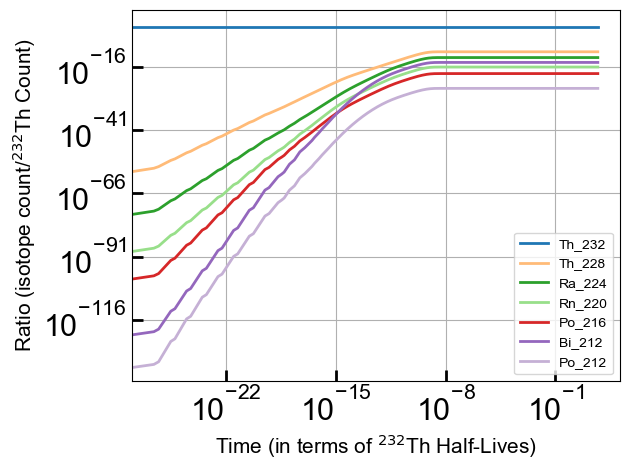

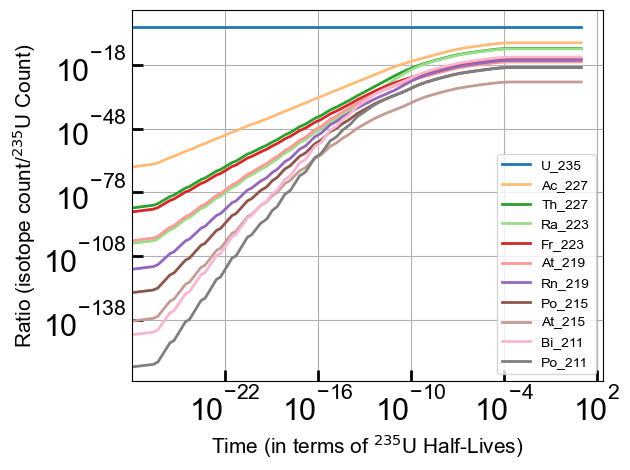

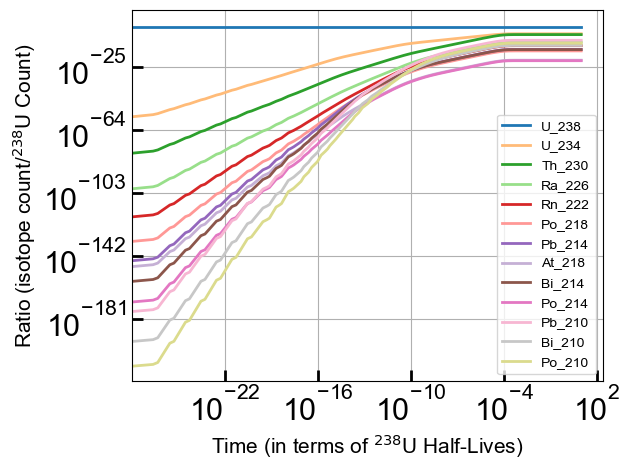

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


#Get the initial counts
Th_counts0=[]
for i in dc.th_chain_isotope_list:
    Th_counts0.append(i.count)

U_counts0=[]
for i in dc.u_chain_isotope_list:
    U_counts0.append(i.count)   
    
U238_counts0=[]
for i in dc.u238_chain_isotope_list:
    U238_counts0.append(i.count)

tmax_th=2*dc.HL_Th
timestep_th = 0.1*dc.HL_Th
t_th=np.arange(0, tmax_th, timestep_th)
# it got screwy after changing t_eval

sol_th = solve_ivp(dc.returns_dNndt, [0, 50*dc.HL_Th], Th_counts0, args=(dc.th_chain_isotope_list,), method='BDF')
#, t_eval=t_th
sol_u = solve_ivp(dc.returns_dNndt, [0, 10*dc.HL_U], U_counts0, args=(dc.u_chain_isotope_list,), method = 'BDF')
sol_u238 = solve_ivp(dc.returns_dNndt, [0, 10*dc.U_238.half_life], U238_counts0, args=(dc.u238_chain_isotope_list,), method = 'BDF')

# Plot results
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(19)]

# Plot for Thorium chain
fTh = plt.figure()
ax1 = fTh.add_subplot()

for i, isotope in enumerate(dc.th_chain_isotope_list):
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) and (isotope.name != "Pb_208"):
        ax1.plot(sol_th.t/dc.HL_Th, sol_th.y[i] / sol_th.y[0], label=isotope.name, color=colors[i])

ax1.set_xlabel(r'Time (in terms of $^{232}$Th Half-Lives)', fontsize=15)
ax1.set_ylabel(r'Ratio (isotope count/$^{232}$Th Count)', fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc=4, fontsize=10)
ax1.grid(True)
fTh.tight_layout()

# Plot for Uranium chain
fU = plt.figure()
ax2 = fU.add_subplot()

for i, isotope in enumerate(dc.u_chain_isotope_list):
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) and (isotope.name != "Pb_207"):
        ax2.plot(sol_u.t/dc.HL_U, sol_u.y[i] / sol_u.y[0], label=isotope.name, color=colors[i])

ax2.set_xlabel(r'Time (in terms of $^{235}$U Half-Lives)', fontsize=15)
ax2.set_ylabel(r'Ratio (isotope count/$^{235}$U Count)', fontsize=15)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(loc=4, fontsize=10)
ax2.grid(True)
fU.tight_layout()

fU238 = plt.figure()
ax3 = fU238.add_subplot()

for i, isotope in enumerate(dc.u238_chain_isotope_list):
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) and (isotope.name != "Pb_206"):
        ax3.plot(sol_u238.t/dc.U_238.half_life, sol_u238.y[i] / sol_u238.y[0], label=isotope.name, color=colors[i])
        

ax3.set_xlabel(r'Time (in terms of $^{238}$U Half-Lives)', fontsize=15)
ax3.set_ylabel(r'Ratio (isotope count/$^{238}$U Count)',fontsize=15)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(loc=4, fontsize=10)
ax3.grid(True)
fU238.tight_layout()

plt.show()
# new_ticks = plt.gca().get_xticks()/dc.HL_Th
# plt.gca().set_xticks([f"{tick:.2g}" for tick in new_ticks])

#print(10e-9*Th_232.half_life)


The 232-Thorium decay chain seems to reach secular equilibrium after $10^{-10}$ half lives, or around 1.41 years. The 235-Uranium chain reaches secular equilibrium at roughly $10^{-6}$ uranium half lives, 704 years.

0.0007428460403797822


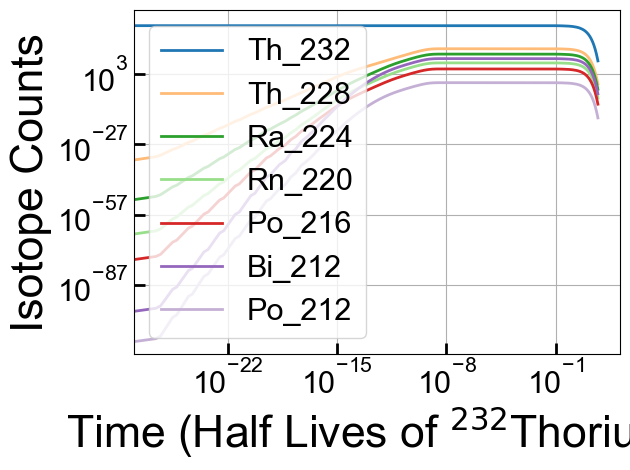

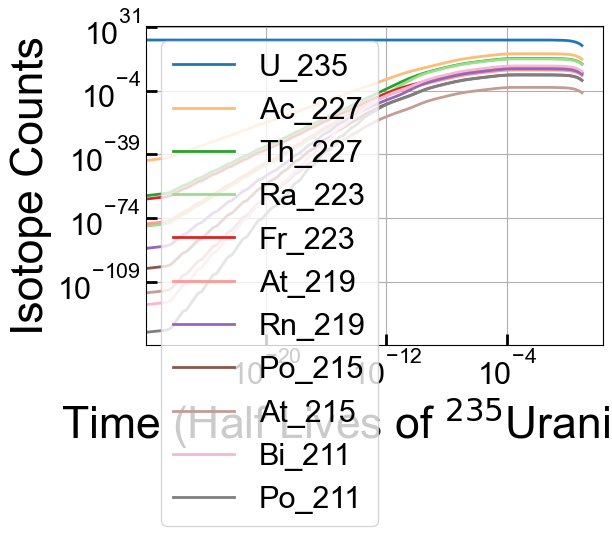

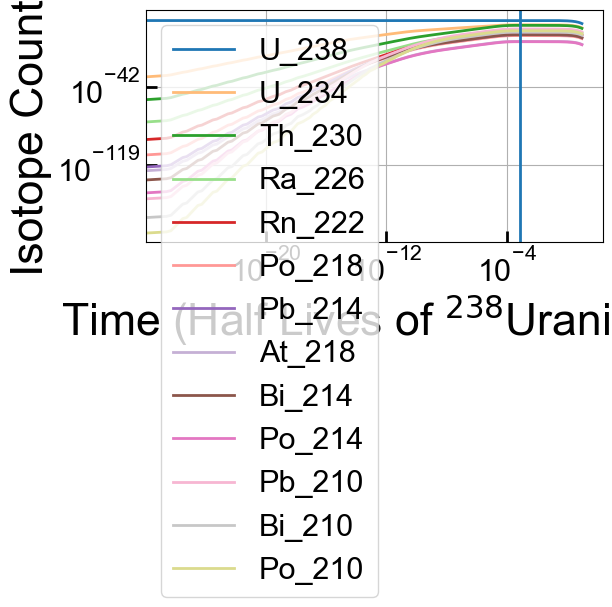

In [8]:
#just pure isotope counts instead of normalized

import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(19)]

# Plot for Thorium chain
fTh = plt.figure()
ax1 = fTh.add_subplot()

for i, isotope in enumerate(dc.th_chain_isotope_list):
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) and (isotope.name != "Pb_208"):
        ax1.plot(sol_th.t/dc.HL_Th, sol_th.y[i] , label=isotope.name, color=colors[i])

ax1.set_xlabel(r'Time (Half Lives of $^{232}$Thorium)')
ax1.set_ylabel(r'Isotope Counts')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='best')
ax1.grid(True)
fTh.tight_layout()

# Plot for Uranium chain
fU = plt.figure()
ax2 = fU.add_subplot()

for i, isotope in enumerate(dc.u_chain_isotope_list):
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) and (isotope.name != "Pb_207"):
        ax2.plot(sol_u.t/dc.HL_U, sol_u.y[i] , label=isotope.name, color=colors[i])

ax2.set_xlabel(r'Time (Half Lives of $^{235}$Uranium)')
ax2.set_ylabel(r'Isotope Counts')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(loc='best')
ax2.grid(True)
fU.tight_layout()

fU238 = plt.figure()
ax3 = fU238.add_subplot()

sum_max_t=0
for i, isotope in enumerate(dc.u238_chain_isotope_list):
    if(isotope.name != "U_238") and (isotope.name != "Pb_206"):
        sum_max_t+=sol_u238.t[np.argmax(sol_u238.y[i])]
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) and (isotope.name != "Pb_206"):
        ax3.plot(sol_u238.t/dc.U_238.half_life, sol_u238.y[i] , label=isotope.name, color=colors[i])

mean=sum_max_t/dc.U_238.half_life/(len(dc.u238_chain_isotope_list)-2)
print(mean)

ax3.set_xlabel(r'Time (Half Lives of $^{238}$Uranium)')
ax3.set_ylabel(r'Isotope Counts')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(loc='best')
ax3.axvline(x=mean)
ax3.grid(True)
fU238.tight_layout()


plt.show()



# To Do

find the secular equilibrium by calculating the maximum and earliest time it gets within some percentage of it